In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
from dask import dataframe as df1
import warnings
import os

os.getcwd()
os.chdir(r"C:\Users\yekaa\Downloads")

C:\Users\yekaa\anaconda3.0\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\yekaa\anaconda3.0\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\yekaa\anaconda3.0\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
f = pd.read_csv("my_data.csv")

In [3]:
f.head()
f.shape

(1995022, 93)

In [4]:
X = f.drop(['Pred_Default','census_tract','agg_class','Ethnicity', 'countyname'], axis=1)
y = f['Pred_Default']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [5]:
X_t = X_train

In [6]:
### Upsample Minority Class Using resample

## Imbalance Sampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

from sklearn.utils import resample
# separate minority and majority classes
not_def = X[X['Pred_Default']==0]
defa = X[X['Pred_Default']==1]

# upsample minority
fraud_upsampled = resample(defa,
                          replace=True, # sample with replacement
                          n_samples=len(not_def), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_def, fraud_upsampled])

# check new class counts
upsampled['Pred_Default'].value_counts()

# trying logistic regression again with the balanced dataset
y_train = upsampled['Pred_Default']
X_train = upsampled.drop('Pred_Default', axis=1)

np.unique(y_test, return_counts=True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2783326, 88)
(598507, 88)
(2783326,)
(598507,)


In [8]:
#train random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth= 18, max_features= 'sqrt', n_estimators= 200)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, max_features='sqrt', n_estimators=200)

In [9]:
train_score_rf = rf.score(X_train, y_train)
test_score_rf = rf.score(X_test, y_test)
print('Train Accuracy Score', train_score_rf)
print('Test Accuracy Score', test_score_rf)

Train Accuracy Score 0.9975791552983733
Test Accuracy Score 0.9944812675540972


In [10]:
prob_rf = rf.predict_proba(X_test)
df_prob_rf = pd.DataFrame(prob_rf)
df_prob_rf.head()

,0,1
0,0.999985,0.000015
1,1.000000,0.000000
2,0.999862,0.000138
3,0.998616,0.001384
4,0.990327,0.009673


In [11]:
pred_rf = rf.predict(X_test)
df_pred_rf = pd.DataFrame(pred_rf)
df_pred_rf.head()

,0
0,0
1,0
2,0
3,0
4,0


<AxesSubplot:>

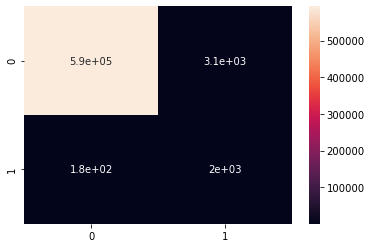

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix_rf = confusion_matrix(y_test, pred_rf)
sns.heatmap(cf_matrix_rf,annot=True)

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    596356
           1       0.39      0.91      0.54      2151

    accuracy                           0.99    598507
   macro avg       0.69      0.95      0.77    598507
weighted avg       1.00      0.99      1.00    598507



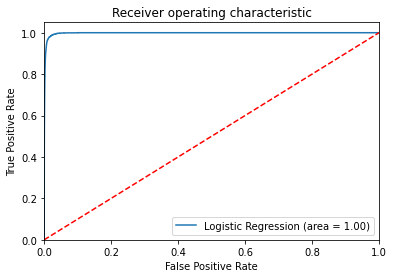

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, prob_rf[:,1])
fpr, tpr, thresholds = roc_curve(y_test, prob_rf[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [15]:
fi = pd.DataFrame({'feature': X_t.columns, 'importance': rf.feature_importances_}).sort_values(by='importance', ascending=False)
fi = fi.reset_index()
fi.head(20)

,index,feature,importance
0,4,interest_rate,0.350245
1,2,loan_to_value_ratio,0.102818
2,3,debt_to_income_ratio,0.084491
3,57,loan_purpose_32,0.063476
4,8,property_value,0.045398
5,1,loan_amount,0.031217
6,55,loan_purpose_1,0.027041
7,20,derived_loan_product_type_Conventional:First Lien,0.026638
8,56,loan_purpose_31,0.023308
9,7,loan_term,0.022741


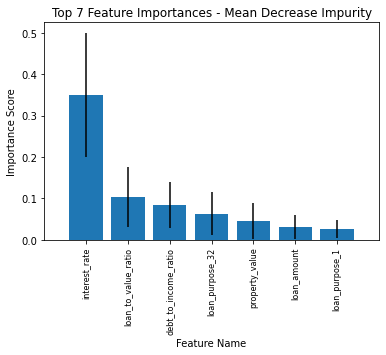

In [16]:
# Calculate feature importances using MDI
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

feature_names = X_t.columns

# Plot top 10 feature importances
top_k = 7
plt.figure()
plt.title("Top {} Feature Importances - Mean Decrease Impurity".format(top_k))
plt.bar(range(top_k), importances[indices][:top_k], yerr=std[indices][:top_k], align="center")
plt.xticks(range(top_k), np.array(feature_names)[indices][:top_k], fontsize=8, rotation='vertical')
plt.xlim([-1, top_k])
plt.xlabel("Feature Name")
plt.ylabel("Importance Score")
plt.show()

In [8]:
#train logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C =0.29, penalty = 'l2', solver = 'sag')
lr.fit(X_train, y_train)

C:\Users\yekaa\anaconda3.0\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=0.29, solver='sag')

In [9]:
train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)
print('Train Accuracy Score', train_score_lr)
print('Test Accuracy Score', test_score_lr)

Train Accuracy Score 0.9921579434101503
Test Accuracy Score 0.9843326811549405


In [10]:
prob_lr = lr.predict_proba(X_test)
df_prob_lr = pd.DataFrame(prob_lr)
df_prob_lr.head()

,0,1
0,1.000000,1.079013e-07
1,0.999999,6.344891e-07
2,0.999995,5.053664e-06
3,0.999999,8.314742e-07
4,0.994544,5.456333e-03


In [11]:
pred_lr = lr.predict(X_test)
df_pred_lr = pd.DataFrame(pred_lr)
df_pred_lr.head()

,0
0,0
1,0
2,0
3,0
4,0


<AxesSubplot:>

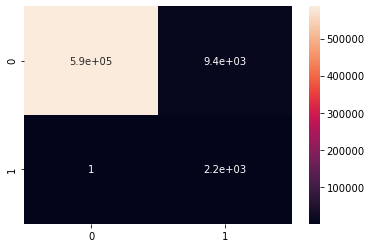

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix_lr = confusion_matrix(y_test, pred_lr)
sns.heatmap(cf_matrix_lr,annot=True)

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    596356
           1       0.19      1.00      0.31      2151

    accuracy                           0.98    598507
   macro avg       0.59      0.99      0.65    598507
weighted avg       1.00      0.98      0.99    598507



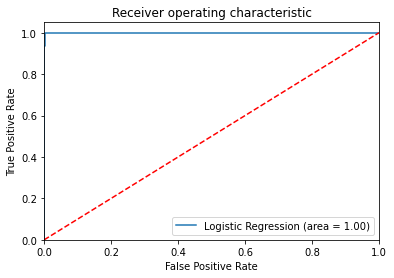

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, prob_lr[:,1])
fpr, tpr, thresholds = roc_curve(y_test, prob_lr[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [17]:
import math
coef = lr.coef_
coef_var = []
coef_exp = []

for x in coef:
  for c in x:
    coef_var.append(c)
    exp = math.exp(c)
    coef_exp.append(exp)
variables = X_t.columns
coef = list(zip(variables, coef_var, coef_exp))
coef_df = pd.DataFrame(coef, columns=['Variables','Coefficients','Odds Ratio'])

inter = lr.intercept_[0]
inter_exp = math.exp(inter)
const = 'Constant'

l = [const, inter, inter_exp]
coef_df.loc[len(coef_df)] = l
coef_df

,Variables,Coefficients,Odds Ratio
0,agg_ff,-0.021538,0.978692
1,loan_amount,-1.133534,0.321894
2,loan_to_value_ratio,2.346485,10.448775
3,debt_to_income_ratio,2.126494,8.385415
4,interest_rate,5.327223,205.865480
...,...,...,...
84,applicant_age_<25,-0.000995,0.999005
85,applicant_age_>74,-0.012638,0.987442
86,loan_purpose_other,-1.326777,0.265331
87,FICO,0.000000,1.000000


In [29]:
c_df = coef_df.sort_values(by="Coefficients", ascending=False)
c_df.head(20)

,Variables,Coefficients,Odds Ratio
4,interest_rate,5.327223,205.865480
2,loan_to_value_ratio,2.346485,10.448775
3,debt_to_income_ratio,2.126494,8.385415
7,loan_term,1.824797,6.201537
57,loan_purpose_32,1.604511,4.975428
21,derived_loan_product_type_Conventional:Subordi...,0.269493,1.309300
67,hoepa_status_1,0.182773,1.200542
44,purchaser_type_0,0.152168,1.164356
6,origination_charges,0.151552,1.163639
26,derived_loan_product_type_VA:First Lien,0.132883,1.142116


In [24]:
# Create a DataFrame to store the feature importances
importance_df = pd.DataFrame({"Feature": X_t.columns, "Importance": lr.coef_[0]})

# Sort the DataFrame by importance values in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

importance_10 = importance_df.head(10)
importance_10

,Feature,Importance
4,interest_rate,5.327223
2,loan_to_value_ratio,2.346485
3,debt_to_income_ratio,2.126494
7,loan_term,1.824797
57,loan_purpose_32,1.604511
21,derived_loan_product_type_Conventional:Subordi...,0.269493
67,hoepa_status_1,0.182773
44,purchaser_type_0,0.152168
6,origination_charges,0.151552
26,derived_loan_product_type_VA:First Lien,0.132883


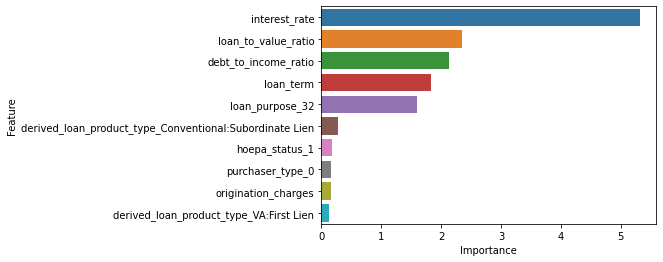

In [26]:
# Create scatter plot with hue
ax = sns.barplot(x="Importance", y="Feature", data=importance_10)
# Move the legend to the right side
# Show plot
plt.show()

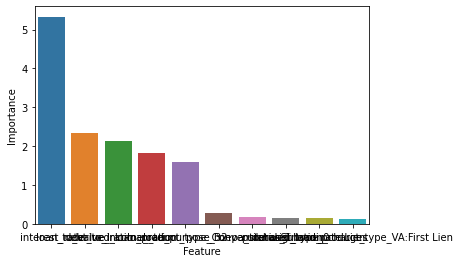

In [27]:
# Create scatter plot with hue
ax = sns.barplot(x="Feature", y="Importance", data=importance_10)
# Move the legend to the right side
# Show plot
plt.show()